In [91]:
# Install and load required packages
if (!require("rio", quietly = TRUE)) install.packages("rio")
if (!require("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!require("dplyr", quietly = TRUE)) install.packages("dplyr")
if (!require("tidyr", quietly = TRUE)) install.packages("tidyr")
library(rio); library(ggplot2); library(dplyr); library(tidyr)

In [92]:
# Set base URL for GitHub raw files (all files will be read from GitHub URLs)
base_url <- "https://github.com/FundamentalsChinmai/LastHW-Ex-01/raw/refs/heads/main/data/"

In [93]:
# Create list of all Excel file names to process (2006-2023)
file_names <- c("fsi-2006.xlsx", "fsi-2007.xlsx", "fsi-2008.xlsx", "fsi-2009.xlsx",
                "fsi-2010.xlsx", "fsi-2011.xlsx", "fsi-2012.xlsx", "fsi-2013.xlsx",
                "fsi-2014.xlsx", "fsi-2015.xlsx", "fsi-2016.xlsx", "fsi-2017.xlsx",
                "fsi-2018.xlsx", "fsi-2019.xlsx", "fsi-2020.xlsx", "fsi-2021.xlsx",
                "fsi-2022-download.xlsx", "FSI-2023-DOWNLOAD.xlsx")

In [94]:
# Define expected column names for final output (columns to keep after cleaning)
expected_cols <- c("Country", "Year", "Rank", "Total", "C1_Security_Apparatus",
                   "C2_Factionalized_Elites", "C3_Group_Grievance", "E1_Economy",
                   "E2_Economic_Inequality", "E3_Human_Flight_and_Brain_Drain",
                   "P1_State_Legitimacy", "P2_Public_Services", "P3_Human_Rights",
                   "S1_Demographic_Pressures", "S2_Refugees_and_IDPs", "X1_External_Intervention")

In [95]:
# Function to map actual column names to expected names (handles variations like "C1: Security Apparatus" -> "C1_Security_Apparatus")
map_column_names <- function(df_cols, expected_cols) {
  name_mapping <- list(
    "C1_Security_Apparatus" = c("C1_Security_Apparatus", "C1 Security Apparatus", "C1: Security Apparatus"),
    "C2_Factionalized_Elites" = c("C2_Factionalized_Elites", "C2 Factionalized Elites", "C2: Factionalized Elites"),
    "C3_Group_Grievance" = c("C3_Group_Grievance", "C3 Group Grievance", "C3: Group Grievance"),
    "E1_Economy" = c("E1_Economy", "E1 Economy", "E1: Economy"),
    "E2_Economic_Inequality" = c("E2_Economic_Inequality", "E2 Economic Inequality", "E2: Economic Inequality"),
    "E3_Human_Flight_and_Brain_Drain" = c("E3_Human_Flight_and_Brain_Drain", "E3 Human Flight and Brain Drain", "E3: Human Flight and Brain Drain"),
    "P1_State_Legitimacy" = c("P1_State_Legitimacy", "P1 State Legitimacy", "P1: State Legitimacy"),
    "P2_Public_Services" = c("P2_Public_Services", "P2 Public Services", "P2: Public Services"),
    "P3_Human_Rights" = c("P3_Human_Rights", "P3 Human Rights", "P3: Human Rights"),
    "S1_Demographic_Pressures" = c("S1_Demographic_Pressures", "S1 Demographic Pressures", "S1: Demographic Pressures"),
    "S2_Refugees_and_IDPs" = c("S2_Refugees_and_IDPs", "S2 Refugees and IDPs", "S2: Refugees and IDPs"),
    "X1_External_Intervention" = c("X1_External_Intervention", "X1 External Intervention", "X1: External Intervention")
  )
  mapped_cols <- character(length(expected_cols))
  names(mapped_cols) <- expected_cols
  for (expected in expected_cols) {
    if (expected %in% names(name_mapping)) {
      for (col in df_cols) {
        if (col %in% name_mapping[[expected]]) {
          mapped_cols[expected] <- col
          break
        }
      }
    } else {
      for (col in df_cols) {
        if (tolower(col) == tolower(expected)) {
          mapped_cols[expected] <- col
          break
        }
      }
    }
  }
  return(mapped_cols)
}

In [96]:
# Function to clean and transform data: ensures Year and Rank are integers, maps columns correctly
clean_data <- function(df) {
  df_cols <- colnames(df)
  mapped_cols <- map_column_names(df_cols, expected_cols)
  cleaned_df <- data.frame(matrix(ncol = length(expected_cols), nrow = nrow(df)))
  colnames(cleaned_df) <- expected_cols
  for (expected_col in expected_cols) {
    if (expected_col %in% names(mapped_cols) && mapped_cols[expected_col] != "" &&
        mapped_cols[expected_col] %in% df_cols) {
      cleaned_df[[expected_col]] <- df[[mapped_cols[expected_col]]]
    }
  }
  # Clean Year column: convert dates (like 20060101) to just the year (2006), ensure it's an integer
  if ("Year" %in% colnames(cleaned_df)) {
    year_values <- cleaned_df$Year
    if (is.numeric(year_values) && any(year_values > 10000, na.rm = TRUE)) {
      year_extracted <- ifelse(nchar(as.character(year_values)) == 8,
                               substr(as.character(year_values), 1, 4),
                               as.character(year_values))
      cleaned_df$Year <- as.integer(year_extracted)
    } else {
      cleaned_df$Year <- as.integer(gsub(".*?(\\d{4}).*", "\\1", as.character(year_values)))
    }
  }
  cleaned_df$Year <- as.integer(cleaned_df$Year)
  # Clean Rank column: remove any text, keep only numbers, convert to integer
  if ("Rank" %in% colnames(cleaned_df)) {
    cleaned_df$Rank <- as.integer(gsub("[^0-9]", "", as.character(cleaned_df$Rank)))
  }
  # Convert all indicator columns to numeric format
  numeric_cols <- c("Total", "C1_Security_Apparatus", "C2_Factionalized_Elites",
                    "C3_Group_Grievance", "E1_Economy", "E2_Economic_Inequality",
                    "E3_Human_Flight_and_Brain_Drain", "P1_State_Legitimacy",
                    "P2_Public_Services", "P3_Human_Rights", "S1_Demographic_Pressures",
                    "S2_Refugees_and_IDPs", "X1_External_Intervention")
  for (col in numeric_cols) {
    if (col %in% colnames(cleaned_df)) cleaned_df[[col]] <- as.numeric(cleaned_df[[col]])
  }
  cleaned_df <- cleaned_df[!is.na(cleaned_df$Country) & cleaned_df$Country != "", ]
  return(cleaned_df)
}

In [97]:
# Initialize empty dataframe to store combined data from all files
combined_data <- NULL

In [98]:
# Loop through each file name to process all Excel files from GitHub
for (file_name in file_names) {
  # Construct full GitHub URL for the file (reading from GitHub, not local)
  file_url <- paste0(base_url, file_name)
  # Read Excel file directly from GitHub URL using rio
  df <- rio::import(file_url)
  # Clean and transform the data (standardize columns, fix Year and Rank formats)
  cleaned_df <- clean_data(df)
  # Append cleaned data vertically to combined_data (stack rows from all files)
  if (is.null(combined_data)) {
    combined_data <- cleaned_df
  } else {
    combined_data <- rbind(combined_data, cleaned_df)
  }
}

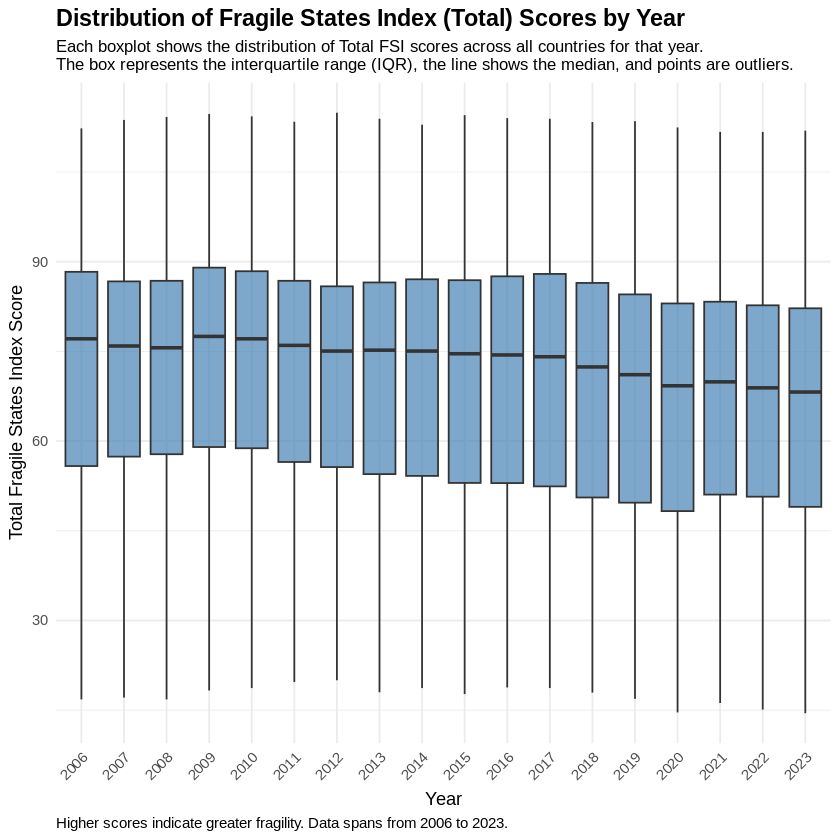

In [99]:
# Plot 1: Boxplot of 'Total' variable per year using ggplot2
ggplot(combined_data, aes(x = factor(Year), y = Total)) +
  geom_boxplot(fill = "steelblue", alpha = 0.7, outlier.color = "red", outlier.alpha = 0.5) +
  labs(title = "Distribution of Fragile States Index (Total) Scores by Year",
       subtitle = "Each boxplot shows the distribution of Total FSI scores across all countries for that year.\nThe box represents the interquartile range (IQR), the line shows the median, and points are outliers.",
       x = "Year", y = "Total Fragile States Index Score",
       caption = "Higher scores indicate greater fragility. Data spans from 2006 to 2023.") +
  theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1, size = 9),
                          plot.title = element_text(size = 14, face = "bold"),
                          plot.subtitle = element_text(size = 10),
                          plot.caption = element_text(size = 9, hjust = 0))

In [100]:
# Plot 2: Histograms for C1, C2, C3 variables for years 2013 and 2023 with facets
# Filter data for years 2013 and 2023 only, select the three security indicators
plot_data <- combined_data %>% filter(Year %in% c(2013, 2023)) %>%
  select(Year, C1_Security_Apparatus, C2_Factionalized_Elites, C3_Group_Grievance)

In [101]:
# Reshape data from wide to long format and create readable variable labels
plot_data <- plot_data %>% pivot_longer(cols = c(C1_Security_Apparatus, C2_Factionalized_Elites, C3_Group_Grievance),
                                        names_to = "Variable", values_to = "Value") %>%
  mutate(Variable_Label = case_when(Variable == "C1_Security_Apparatus" ~ "C1: Security Apparatus",
                                    Variable == "C2_Factionalized_Elites" ~ "C2: Factionalized Elites",
                                    Variable == "C3_Group_Grievance" ~ "C3: Group Grievance"))

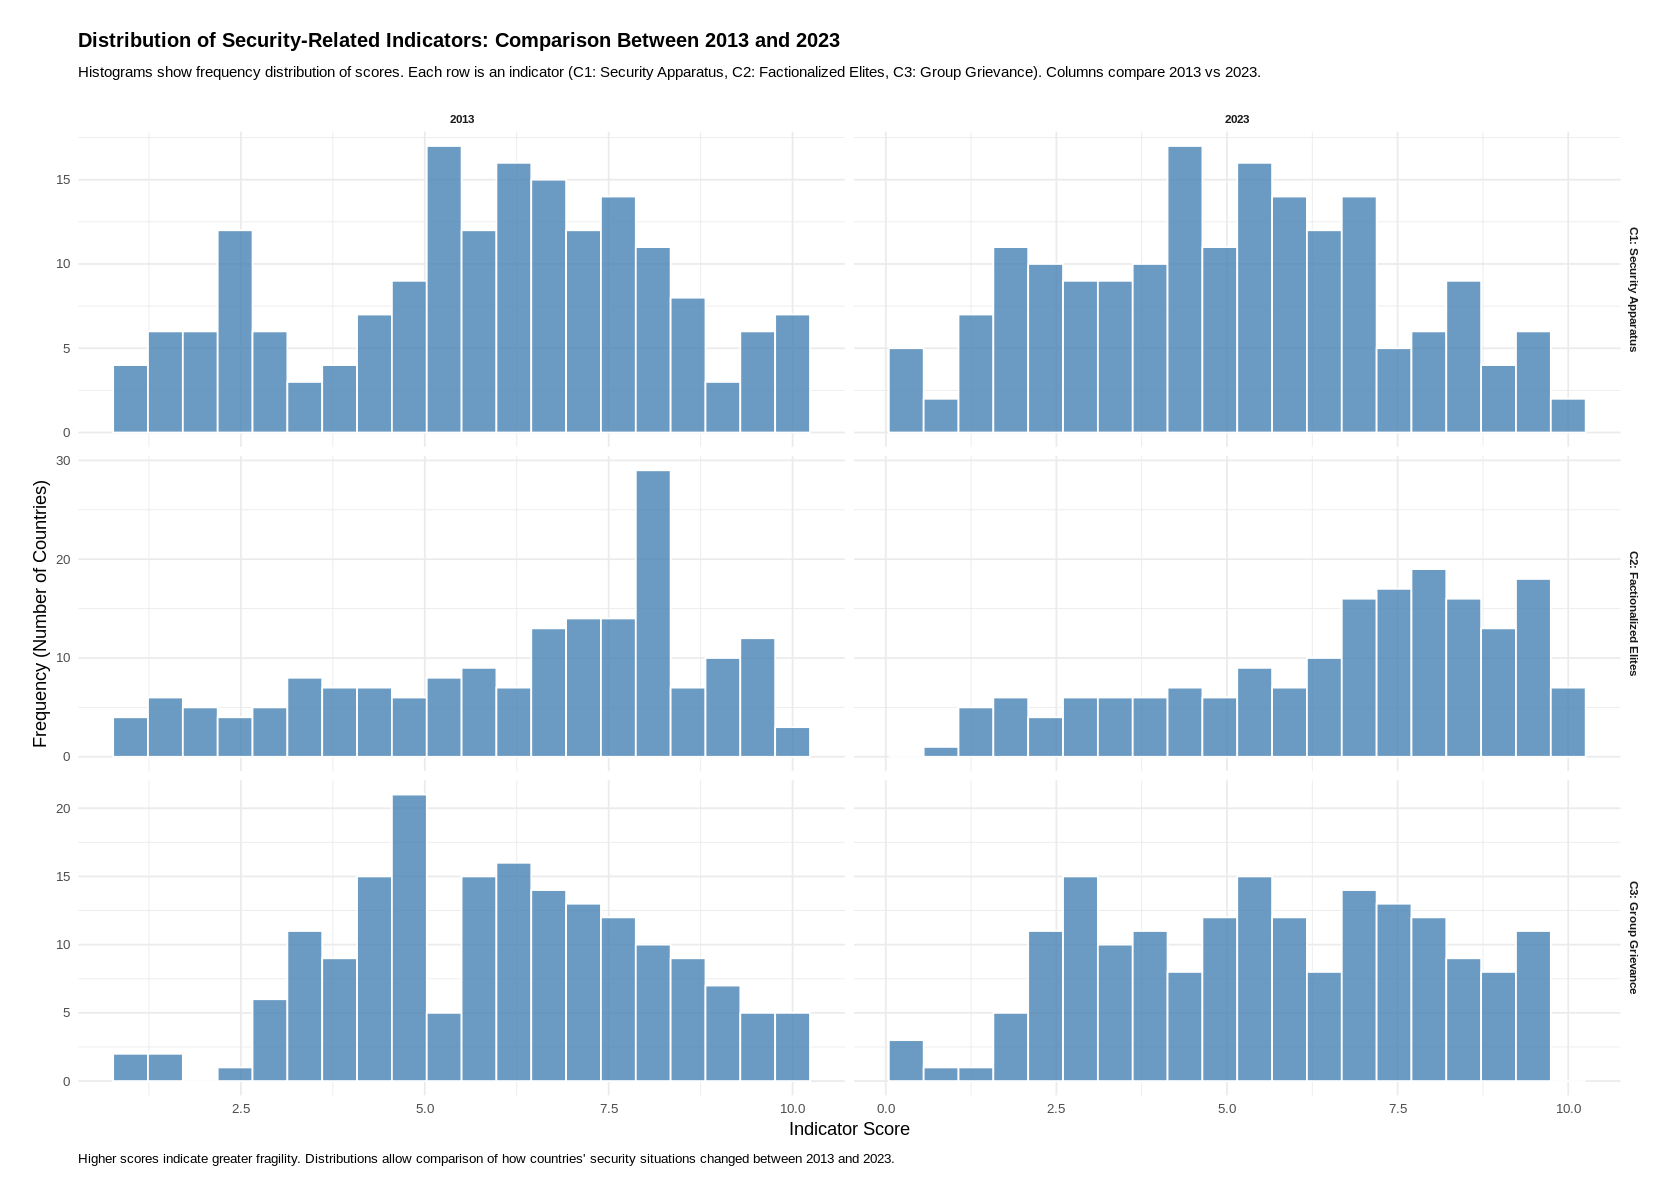

In [ ]:
# Set plot size to make it larger (width and height in inches)
options(repr.plot.width = 14, repr.plot.height = 12)
# Create histogram plot with facets: each row is an indicator, each column is a year
ggplot(plot_data, aes(x = Value)) + geom_histogram(bins = 20, fill = "steelblue", color = "white", alpha = 0.8) +
  facet_grid(Variable_Label ~ factor(Year), scales = "free") +
  labs(title = "Distribution of Security-Related Indicators: Comparison Between 2013 and 2023",
       subtitle = "Histograms show frequency distribution of scores. Each row is an indicator:\nC1: Security Apparatus, C2: Factionalized Elites, C3: Group Grievance. Columns compare 2013 vs 2023.",
       x = "Indicator Score", y = "Frequency (Number of Countries)",
       caption = "Higher scores indicate greater fragility. Distributions allow comparison of how countries' security situations changed between 2013 and 2023.") +
  theme_minimal() + theme(strip.text = element_text(size = 6, face = "bold"),
                           plot.title = element_text(size = 11, face = "bold", margin = margin(b = 8)),
                           plot.subtitle = element_text(size = 8, margin = margin(b = 12)),
                           plot.caption = element_text(size = 7, hjust = 0, margin = margin(t = 8)),
                           axis.text = element_text(size = 7),
                           axis.title = element_text(size = 8),
                           plot.margin = margin(25, 30, 25, 25))